In [8]:
#%% env: new-ml

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic
import shap

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm   
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import pandas as pd
# from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#%%
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, plot_importance


seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

In [9]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts 

In [10]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung_na11182024.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)
clinical_lung_cleaned = clinical_lung.drop_duplicates()
clinical_lung_features = clinical_lung.drop(columns=['outcome', 'period_span.1'])
clinical_lung_target = clinical_lung[['outcome']]

/tmp/ipykernel_23641/1632443557.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)


In [15]:

def evaluate_xgboost_classifier_split_weighted(X_train, X_test, y_train, y_test, reg_alpha=0.1, reg_lambda=0.1, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided training and testing datasets with weighted loss.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - y_test (pd.Series or np.array): Testing target variable.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=np.array(y_train['outcome']))
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Calculate scale_pos_weight for binary classification
    if len(np.unique(y_train)) == 2:
        pos_class_weight = class_weights[1] / class_weights[0]
    else:
        pos_class_weight = None  # Adjust for multiclass if needed

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=random_state,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=pos_class_weight
    )
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(25, 55))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

## Train

In [13]:
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
# evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

# Extract feature importance from the trained model
feature_importances = model.get_booster().get_score(importance_type='weight')

# Convert to a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# Display or save the DataFrame
print(importance_df)

IndexError: invalid index to scalar variable.

In [14]:
print_full(importance_df)


NameError: name 'importance_df' is not defined

## iterative dropping

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames to retain feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize variables
dropped_features = []
remaining_features = list(importance_df['Feature'])  # Start with all features
baseline_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    reg_alpha=38, 
    reg_lambda=69,  
    random_state=42,
)

# Train the baseline model
baseline_model.fit(X_train_scaled_df[remaining_features], y_train_resampled)
y_pred = baseline_model.predict(X_test_scaled_df[remaining_features])
baseline_accuracy = accuracy_score(y_test, y_pred)

# Calculate baseline sensitivity, specificity, and F1 score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
baseline_sensitivity = tp / (tp + fn)  # Recall
baseline_specificity = tn / (tn + fp)
baseline_f1 = f1_score(y_test, y_pred)

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Sensitivity (Recall): {baseline_sensitivity:.4f}")
print(f"Baseline Specificity: {baseline_specificity:.4f}")
print(f"Baseline F1 Score: {baseline_f1:.4f}")

# Reverse the importance dataframe for iterative feature elimination
importance_df_ = importance_df.iloc[::-1].copy()

# Start feature elimination
for feature in importance_df_['Feature']:
    # Remove the least important feature
    remaining_features.remove(feature)
    dropped_features.append(feature)

    # Train the model with remaining features
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        reg_alpha=38, 
        reg_lambda=69,  
        random_state=42,
    )
    model.fit(X_train_scaled_df[remaining_features], y_train_resampled)
    y_pred = model.predict(X_test_scaled_df[remaining_features])

    # Calculate metrics
    current_accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_sensitivity = tp / (tp + fn)  # Recall
    current_specificity = tn / (tn + fp)
    current_f1 = f1_score(y_test, y_pred)

    print(f"After dropping '{feature}':")
    print(f"  Accuracy: {current_accuracy:.4f}")
    print(f"  Sensitivity (Recall): {current_sensitivity:.4f}")
    print(f"  Specificity: {current_specificity:.4f}")
    print(f"  F1 Score: {current_f1:.4f}")

    # Stop if accuracy drops
    if current_accuracy < baseline_accuracy:
        print("\nStopping criteria met.")
        print(f"Features dropped: {dropped_features}")
        print(f"Remaining features: {remaining_features}")
        break
else:
    print("\nAll features tested. Final feature set:")
    print(f"Remaining features: {remaining_features}")


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Baseline Accuracy: 0.9115
Baseline Sensitivity (Recall): 0.9259
Baseline Specificity: 0.8543
Baseline F1 Score: 0.9435


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'A19.8':
  Accuracy: 0.9115
  Sensitivity (Recall): 0.9259
  Specificity: 0.8543
  F1 Score: 0.9435


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Rifampicin':
  Accuracy: 0.9145
  Sensitivity (Recall): 0.9259
  Specificity: 0.8693
  F1 Score: 0.9454


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Pyrazinamide':
  Accuracy: 0.9130
  Sensitivity (Recall): 0.9272
  Specificity: 0.8568
  F1 Score: 0.9445


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Moxifloxacin':
  Accuracy: 0.9125
  Sensitivity (Recall): 0.9259
  Specificity: 0.8593
  F1 Score: 0.9441


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Linezolid':
  Accuracy: 0.9140
  Sensitivity (Recall): 0.9278
  Specificity: 0.8593
  F1 Score: 0.9452


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Kanamycin':
  Accuracy: 0.9125
  Sensitivity (Recall): 0.9259
  Specificity: 0.8593
  F1 Score: 0.9441


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Cycloserine':
  Accuracy: 0.9135
  Sensitivity (Recall): 0.9259
  Specificity: 0.8643
  F1 Score: 0.9447


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping '1 to 19':
  Accuracy: 0.9125
  Sensitivity (Recall): 0.9272
  Specificity: 0.8543
  F1 Score: 0.9442


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Cotrimoxazol preventive':
  Accuracy: 0.9125
  Sensitivity (Recall): 0.9272
  Specificity: 0.8543
  F1 Score: 0.9442


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Amikacin':
  Accuracy: 0.9160
  Sensitivity (Recall): 0.9297
  Specificity: 0.8618
  F1 Score: 0.9465


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Terminated from study':
  Accuracy: 0.9160
  Sensitivity (Recall): 0.9297
  Specificity: 0.8618
  F1 Score: 0.9465


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'bactec_isoniazid':
  Accuracy: 0.9160
  Sensitivity (Recall): 0.9297
  Specificity: 0.8618
  F1 Score: 0.9465


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'totalcavernum':
  Accuracy: 0.9135
  Sensitivity (Recall): 0.9259
  Specificity: 0.8643
  F1 Score: 0.9447


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'isanyclusterednoduleexists':
  Accuracy: 0.9135
  Sensitivity (Recall): 0.9259
  Specificity: 0.8643
  F1 Score: 0.9447
After dropping 'isanynoncalcifiednoduleexist':
  Accuracy: 0.9095
  Sensitivity (Recall): 0.9234
  Specificity: 0.8543
  F1 Score: 0.9422

Stopping criteria met.
Features dropped: ['A19.8', 'Rifampicin', 'Pyrazinamide', 'Moxifloxacin', 'Linezolid', 'Kanamycin', 'Cycloserine', '1 to 19', 'Cotrimoxazol preventive', 'Amikacin', 'Terminated from study', 'bactec_isoniazid', 'totalcavernum', 'isanyclusterednoduleexists', 'isanynoncalcifiednoduleexist']
Remaining features: ['period_span', 'country', 'age_of_onset', 'type_of_resistance', 'Patient stopped treatment', 'Pretomanid', 'timika_score', 'bmi', 'number_of_daily_contacts', 'case_definition', 'Negative', 'education', 'Imipenem-cilastatin', 'Treatment ended', 'Unknown result', '100 to 200', 'p-aminosalicylic acid', 'Not specified', 'Treatment ineffective due to additional resistance', 'smallnodules', 'Not

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:56:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [54]:
X_train['regimen_count']

3881    2.0
9156    2.0
8812    1.0
867     1.0
5148    1.0
       ... 
2835    1.0
1118    1.0
2965    1.0
3062    1.0
2017    1.0
Name: regimen_count, Length: 7904, dtype: float64

### keep dropping

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Baseline Accuracy: 0.9115
Baseline F1 Score: 0.9435


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'A19.8':
  Accuracy: 0.9115
  F1 Score: 0.9435
  Sensitivity (Recall): 0.9259
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Rifampicin':
  Accuracy: 0.9145
  F1 Score: 0.9454
  Sensitivity (Recall): 0.9259
  Specificity: 0.8693


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Pyrazinamide':
  Accuracy: 0.9130
  F1 Score: 0.9445
  Sensitivity (Recall): 0.9272
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Moxifloxacin':
  Accuracy: 0.9125
  F1 Score: 0.9441
  Sensitivity (Recall): 0.9259
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Linezolid':
  Accuracy: 0.9140
  F1 Score: 0.9452
  Sensitivity (Recall): 0.9278
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Kanamycin':
  Accuracy: 0.9125
  F1 Score: 0.9441
  Sensitivity (Recall): 0.9259
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Cycloserine':
  Accuracy: 0.9135
  F1 Score: 0.9447
  Sensitivity (Recall): 0.9259
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping '1 to 19':
  Accuracy: 0.9125
  F1 Score: 0.9442
  Sensitivity (Recall): 0.9272
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Cotrimoxazol preventive':
  Accuracy: 0.9125
  F1 Score: 0.9442
  Sensitivity (Recall): 0.9272
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Amikacin':
  Accuracy: 0.9160
  F1 Score: 0.9465
  Sensitivity (Recall): 0.9297
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Terminated from study':
  Accuracy: 0.9160
  F1 Score: 0.9465
  Sensitivity (Recall): 0.9297
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'bactec_isoniazid':
  Accuracy: 0.9160
  F1 Score: 0.9465
  Sensitivity (Recall): 0.9297
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'totalcavernum':
  Accuracy: 0.9135
  F1 Score: 0.9447
  Sensitivity (Recall): 0.9259
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'isanyclusterednoduleexists':
  Accuracy: 0.9135
  F1 Score: 0.9447
  Sensitivity (Recall): 0.9259
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'isanynoncalcifiednoduleexist':
  Accuracy: 0.9095
  F1 Score: 0.9422
  Sensitivity (Recall): 0.9234
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'pleural_effusion_percent_of_hemithorax_involved':
  Accuracy: 0.9115
  F1 Score: 0.9435
  Sensitivity (Recall): 0.9253
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Nonspecific microflora':
  Accuracy: 0.9079
  F1 Score: 0.9411
  Sensitivity (Recall): 0.9215
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Antiretroviral therapy':
  Accuracy: 0.9110
  F1 Score: 0.9431
  Sensitivity (Recall): 0.9240
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Patient alcohol abuse not available/unknown':
  Accuracy: 0.9120
  F1 Score: 0.9438
  Sensitivity (Recall): 0.9253
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Not Reported.3':
  Accuracy: 0.9120
  F1 Score: 0.9438
  Sensitivity (Recall): 0.9259
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Immigrants':
  Accuracy: 0.9145
  F1 Score: 0.9455
  Sensitivity (Recall): 0.9284
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Worked abroad':
  Accuracy: 0.9125
  F1 Score: 0.9442
  Sensitivity (Recall): 0.9265
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Clofazimine':
  Accuracy: 0.9105
  F1 Score: 0.9427
  Sensitivity (Recall): 0.9227
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Homeless':
  Accuracy: 0.9150
  F1 Score: 0.9459
  Sensitivity (Recall): 0.9297
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'regimen_count':
  Accuracy: 0.9135
  F1 Score: 0.9448
  Sensitivity (Recall): 0.9265
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Ex prisoner':
  Accuracy: 0.9135
  F1 Score: 0.9448
  Sensitivity (Recall): 0.9265
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Psychiatric illness':
  Accuracy: 0.9140
  F1 Score: 0.9451
  Sensitivity (Recall): 0.9259
  Specificity: 0.8668


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Patient smoking data not available/unknown':
  Accuracy: 0.9155
  F1 Score: 0.9461
  Sensitivity (Recall): 0.9284
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'overall_percent_of_abnormal_volume':
  Accuracy: 0.9155
  F1 Score: 0.9462
  Sensitivity (Recall): 0.9297
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'A15.1':
  Accuracy: 0.9155
  F1 Score: 0.9462
  Sensitivity (Recall): 0.9303
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'A16.0':
  Accuracy: 0.9145
  F1 Score: 0.9455
  Sensitivity (Recall): 0.9291
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'infiltrate_highdensity':
  Accuracy: 0.9165
  F1 Score: 0.9469
  Sensitivity (Recall): 0.9310
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'A15.0':
  Accuracy: 0.9130
  F1 Score: 0.9444
  Sensitivity (Recall): 0.9259
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'lowgroundglassdensityactivefreshnodules':
  Accuracy: 0.9125
  F1 Score: 0.9442
  Sensitivity (Recall): 0.9265
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'isanycalcifiedorpartiallycalcifiednoduleexist':
  Accuracy: 0.9125
  F1 Score: 0.9441
  Sensitivity (Recall): 0.9259
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'genexpert_test':
  Accuracy: 0.9135
  F1 Score: 0.9449
  Sensitivity (Recall): 0.9284
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'largenodules':
  Accuracy: 0.9135
  F1 Score: 0.9448
  Sensitivity (Recall): 0.9272
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'largecavities':
  Accuracy: 0.9165
  F1 Score: 0.9468
  Sensitivity (Recall): 0.9291
  Specificity: 0.8668


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'collapse':
  Accuracy: 0.9160
  F1 Score: 0.9465
  Sensitivity (Recall): 0.9303
  Specificity: 0.8593
After dropping 'lung_localization':
  Accuracy: 0.9145
  F1 Score: 0.9455
  Sensitivity (Recall): 0.9284
  Specificity: 0.8593


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'HIV':
  Accuracy: 0.9125
  F1 Score: 0.9441
  Sensitivity (Recall): 0.9259
  Specificity: 0.8593
After dropping 'Hepatitis C':
  Accuracy: 0.9130
  F1 Score: 0.9444
  Sensitivity (Recall): 0.9259
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Ofloxacin':
  Accuracy: 0.9150
  F1 Score: 0.9458
  Sensitivity (Recall): 0.9284
  Specificity: 0.8618
After dropping 'Not Reported.1':
  Accuracy: 0.9145
  F1 Score: 0.9454
  Sensitivity (Recall): 0.9272
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Adverse event':
  Accuracy: 0.9155
  F1 Score: 0.9461
  Sensitivity (Recall): 0.9291
  Specificity: 0.8618
After dropping 'Bedaquiline':
  Accuracy: 0.9160
  F1 Score: 0.9463
  Sensitivity (Recall): 0.9272
  Specificity: 0.8719


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'mediumcavities':
  Accuracy: 0.9115
  F1 Score: 0.9434
  Sensitivity (Recall): 0.9240
  Specificity: 0.8618
After dropping 'infiltrate_lowgroundglassdensity':
  Accuracy: 0.9130
  F1 Score: 0.9444
  Sensitivity (Recall): 0.9259
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'gender':
  Accuracy: 0.9145
  F1 Score: 0.9455
  Sensitivity (Recall): 0.9291
  Specificity: 0.8568
After dropping 'Ethionamide':
  Accuracy: 0.9140
  F1 Score: 0.9451
  Sensitivity (Recall): 0.9272
  Specificity: 0.8618


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Levofloxacin':
  Accuracy: 0.9135
  F1 Score: 0.9446
  Sensitivity (Recall): 0.9234
  Specificity: 0.8744
After dropping 'Not reported':
  Accuracy: 0.9105
  F1 Score: 0.9426
  Sensitivity (Recall): 0.9202
  Specificity: 0.8719


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'aremultiplenoduleexists':
  Accuracy: 0.9115
  F1 Score: 0.9433
  Sensitivity (Recall): 0.9221
  Specificity: 0.8693
After dropping 'highdensitycalcifiedtypicallysequella':
  Accuracy: 0.9130
  F1 Score: 0.9444
  Sensitivity (Recall): 0.9246
  Specificity: 0.8668


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Patient alcohol abuse':
  Accuracy: 0.9120
  F1 Score: 0.9438
  Sensitivity (Recall): 0.9246
  Specificity: 0.8618
After dropping 'Amoxicillin-clavulanate':
  Accuracy: 0.9095
  F1 Score: 0.9420
  Sensitivity (Recall): 0.9208
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Continuation of treatment':
  Accuracy: 0.9095
  F1 Score: 0.9421
  Sensitivity (Recall): 0.9227
  Specificity: 0.8568
After dropping 'Capreomycin':
  Accuracy: 0.9044
  F1 Score: 0.9387
  Sensitivity (Recall): 0.9170
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Streptomycin':
  Accuracy: 0.9074
  F1 Score: 0.9406
  Sensitivity (Recall): 0.9183
  Specificity: 0.8643
After dropping 'employment':
  Accuracy: 0.9039
  F1 Score: 0.9384
  Sensitivity (Recall): 0.9170
  Specificity: 0.8518


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Not Reported':
  Accuracy: 0.9069
  F1 Score: 0.9404
  Sensitivity (Recall): 0.9189
  Specificity: 0.8593
After dropping 'smallnodules':
  Accuracy: 0.9069
  F1 Score: 0.9403
  Sensitivity (Recall): 0.9177
  Specificity: 0.8643


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Treatment ineffective due to additional resistance':
  Accuracy: 0.9074
  F1 Score: 0.9408
  Sensitivity (Recall): 0.9215
  Specificity: 0.8518
After dropping 'Not specified':
  Accuracy: 0.9039
  F1 Score: 0.9385
  Sensitivity (Recall): 0.9183
  Specificity: 0.8467


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'p-aminosalicylic acid':
  Accuracy: 0.9044
  F1 Score: 0.9387
  Sensitivity (Recall): 0.9164
  Specificity: 0.8568
After dropping '100 to 200':
  Accuracy: 0.9064
  F1 Score: 0.9401
  Sensitivity (Recall): 0.9202
  Specificity: 0.8518


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Unknown result':
  Accuracy: 0.9039
  F1 Score: 0.9385
  Sensitivity (Recall): 0.9177
  Specificity: 0.8492
After dropping 'Treatment ended':
  Accuracy: 0.8892
  F1 Score: 0.9283
  Sensitivity (Recall): 0.8974
  Specificity: 0.8568


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Imipenem-cilastatin':
  Accuracy: 0.8877
  F1 Score: 0.9274
  Sensitivity (Recall): 0.8980
  Specificity: 0.8467
After dropping 'education':
  Accuracy: 0.8892
  F1 Score: 0.9283
  Sensitivity (Recall): 0.8980
  Specificity: 0.8543


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Negative':
  Accuracy: 0.8842
  F1 Score: 0.9249
  Sensitivity (Recall): 0.8930
  Specificity: 0.8492
After dropping 'case_definition':
  Accuracy: 0.8761
  F1 Score: 0.9193
  Sensitivity (Recall): 0.8835
  Specificity: 0.8467


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'number_of_daily_contacts':
  Accuracy: 0.8756
  F1 Score: 0.9190
  Sensitivity (Recall): 0.8835
  Specificity: 0.8442
After dropping 'bmi':
  Accuracy: 0.8741
  F1 Score: 0.9178
  Sensitivity (Recall): 0.8809
  Specificity: 0.8467


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'timika_score':
  Accuracy: 0.8725
  F1 Score: 0.9169
  Sensitivity (Recall): 0.8803
  Specificity: 0.8417
After dropping 'Pretomanid':
  Accuracy: 0.8634
  F1 Score: 0.9103
  Sensitivity (Recall): 0.8676
  Specificity: 0.8467


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'Patient stopped treatment':
  Accuracy: 0.8518
  F1 Score: 0.9025
  Sensitivity (Recall): 0.8588
  Specificity: 0.8241
After dropping 'type_of_resistance':
  Accuracy: 0.8204
  F1 Score: 0.8808
  Sensitivity (Recall): 0.8303
  Specificity: 0.7814
After dropping 'age_of_onset':
  Accuracy: 0.8118
  F1 Score: 0.8733
  Sensitivity (Recall): 0.8119
  Specificity: 0.8116


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


After dropping 'country':
  Accuracy: 0.8128
  F1 Score: 0.8767
  Sensitivity (Recall): 0.8334
  Specificity: 0.7312

Feature elimination complete.
Remaining feature: ['period_span']


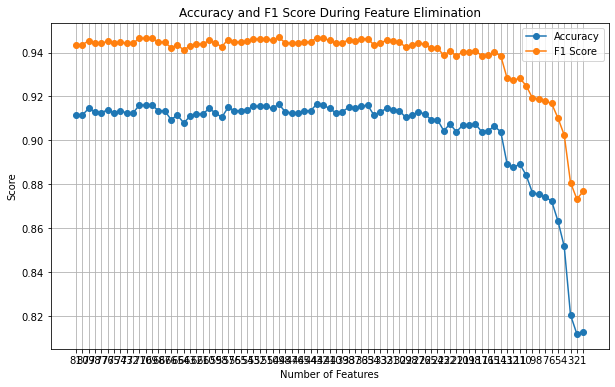

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames to retain feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize variables
dropped_features = []
remaining_features = list(importance_df['Feature'])  # Start with all features
accuracy_scores = []
f1_scores = []

baseline_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    reg_alpha=38, 
    reg_lambda=69,  
    random_state=42,
)

# Train the baseline model
baseline_model.fit(X_train_scaled_df[remaining_features], y_train_resampled)
y_pred = baseline_model.predict(X_test_scaled_df[remaining_features])
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

accuracy_scores.append(baseline_accuracy)
f1_scores.append(baseline_f1)

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline F1 Score: {baseline_f1:.4f}")

# Reverse the importance dataframe for iterative feature elimination
importance_df_ = importance_df.iloc[::-1].copy()

# Start feature elimination
for feature in importance_df_['Feature']:
    if len(remaining_features) == 1:
        break
    
    # Remove the least important feature
    remaining_features.remove(feature)
    dropped_features.append(feature)

    # Train the model with remaining features
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        reg_alpha=38, 
        reg_lambda=69,  
        random_state=42,
    )
    model.fit(X_train_scaled_df[remaining_features], y_train_resampled)
    y_pred = model.predict(X_test_scaled_df[remaining_features])

    # Calculate metrics
    current_accuracy = accuracy_score(y_test, y_pred)
    current_f1 = f1_score(y_test, y_pred)

    # Store metrics
    accuracy_scores.append(current_accuracy)
    f1_scores.append(current_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_sensitivity = tp / (tp + fn)  # Recall
    current_specificity = tn / (tn + fp)
    current_f1 = f1_score(y_test, y_pred)

    print(f"After dropping '{feature}':")
    print(f"  Accuracy: {current_accuracy:.4f}")
    print(f"  F1 Score: {current_f1:.4f}")
    print(f"  Sensitivity (Recall): {current_sensitivity:.4f}")
    print(f"  Specificity: {current_specificity:.4f}")

print("\nFeature elimination complete.")
print(f"Remaining feature: {remaining_features}")

# Plot the accuracy and F1 scores
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_scores)), accuracy_scores, label="Accuracy", marker="o")
plt.plot(range(len(f1_scores)), f1_scores, label="F1 Score", marker="o")
plt.xticks(range(len(accuracy_scores)), labels=[len(remaining_features) + len(dropped_features) - i for i in range(len(accuracy_scores))])
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Accuracy and F1 Score During Feature Elimination")
plt.legend()
plt.grid()
plt.show()


## SHAP value

In [33]:
explainer = shap.Explainer(model.predict, X_train_resampled)
shap_values = explainer(X_train_resampled)

# If classification, and you need SHAP values for probabilities:
explainer = shap.Explainer(lambda x: model.predict_proba(x), X_train_resampled)
shap_values = explainer(X_train_resampled)


Permutation explainer: 12623it [21:58,  9.52it/s]                           
Permutation explainer: 12623it [22:30,  9.27it/s]                           


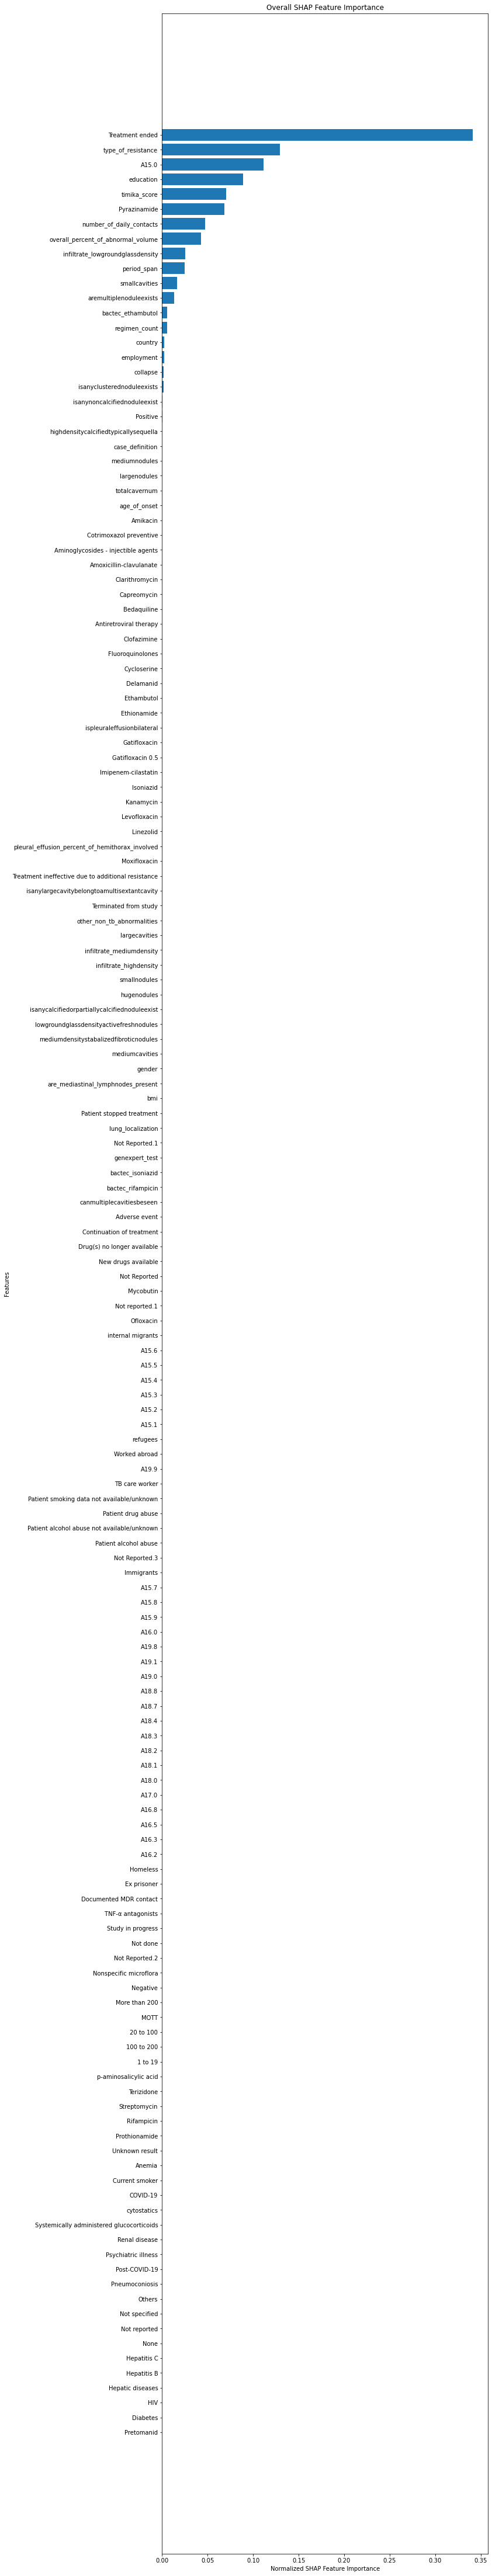

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Aggregate SHAP values by summing the absolute values across samples and classes
feature_importance = np.sum(np.abs(shap_values.values), axis=(0, 2))

# Normalize (optional)
feature_importance_normalized = feature_importance / feature_importance.sum()

# Get feature names (if available) or create dummy names
if isinstance(X_train_resampled, pd.DataFrame):
    feature_names = X_train_resampled.columns
else:
    feature_names = [f"Feature {i}" for i in range(len(feature_importance))]

# Sort features by importance for better visualization
sorted_idx = np.argsort(feature_importance_normalized)[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importance = feature_importance_normalized[sorted_idx]

# Plot Feature Importance
plt.figure(figsize=(10, 80))
plt.barh(sorted_features, sorted_importance, align='center')
plt.xlabel("Normalized SHAP Feature Importance")
plt.ylabel("Features")
plt.title("Overall SHAP Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


<Figure size 7200x5760 with 0 Axes>

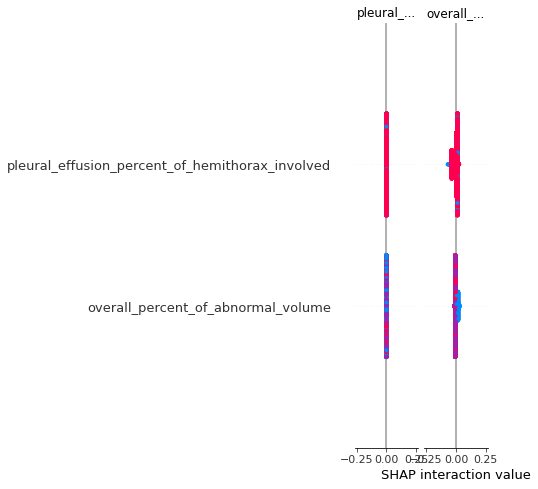

Original size: [6. 4.]
New size: [6.  4.5]


<Figure size 432x324 with 0 Axes>

In [75]:
# interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train_resampled)
# shap.summary_plot(interaction_values, X_train_resampled)
plt.figure(figsize=(100, 80))

shap.summary_plot(shap_values.values, X_train_resampled, plot_size=[80,60])

# Add this code
print(f'Original size: {plt.gcf().get_size_inches()}')
w, _ = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w, w*3/4)
plt.tight_layout()
print(f'New size: {plt.gcf().get_size_inches()}')

plt.savefig('fig_tes1.svg', bbox_inches='tight',dpi=100)

In [30]:
X_test[['period_span']]

KeyError: "None of [Index(['period_span'], dtype='object')] are in the [columns]"

## dropping period_span

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:32:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing Accuracy: 0.8128
Sensitivity (Recall): 0.8334
Specificity: 0.7312


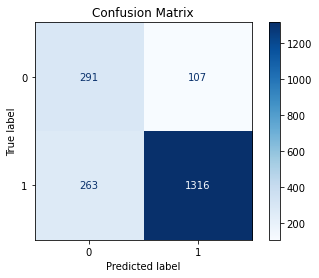

<Figure size 1800x3960 with 0 Axes>

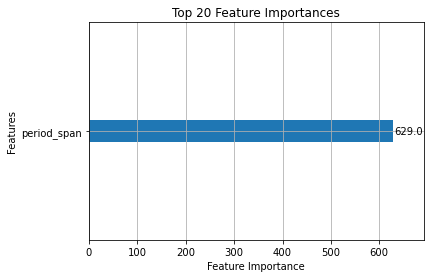

In [33]:
# X_train_resampled_ = X_train_resampled.drop(columns=['period_span'])
# X_test =  X_test.drop(columns=['period_span'])
X_train_resampled_ = X_train_resampled[['period_span']]
X_test_ =  X_test[['period_span']]
model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled_, X_test_, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
##########################################

## removal treatment_ended

In [15]:
X_train_resampled_

0        1.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
12617    1.0
12618    1.0
12619    1.0
12620    0.0
12621    1.0
Name: Treatment ended, Length: 12622, dtype: float64

In [23]:
X_train_resampled[['Treatment ended','Documented MDR contact']]

,Treatment ended,Documented MDR contact
0,1.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,0.0
...,...,...
12617,1.0,0.0
12618,1.0,0.0
12619,1.0,0.0
12620,0.0,0.0


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:27:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing Accuracy: 0.8007
Sensitivity (Recall): 0.8486
Specificity: 0.6106


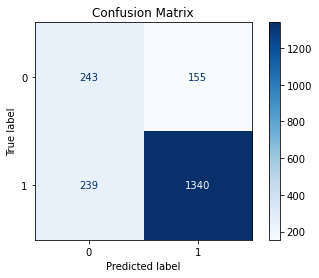

<Figure size 1800x3960 with 0 Axes>

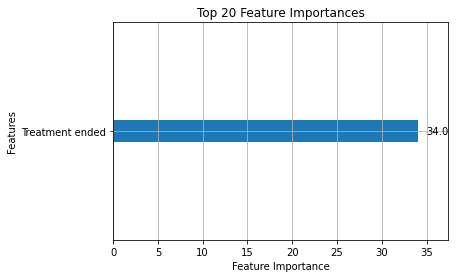

In [24]:
X_train_resampled_ = X_train_resampled.drop(columns=['Treatment ended'])
X_test_ =  X_test.drop(columns=['Treatment ended'])
X_train_resampled_ = X_train_resampled[['Treatment ended']]
X_test_ =  X_test[['Treatment ended']]
model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled_, X_test_, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)


## removal of both treatment_ended and period_span  

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing Accuracy: 0.8513
Sensitivity (Recall): 0.8645
Specificity: 0.7990


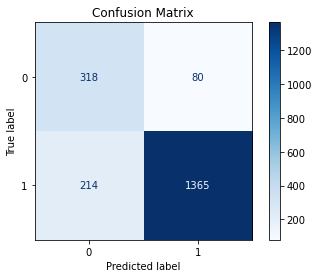

<Figure size 1800x3960 with 0 Axes>

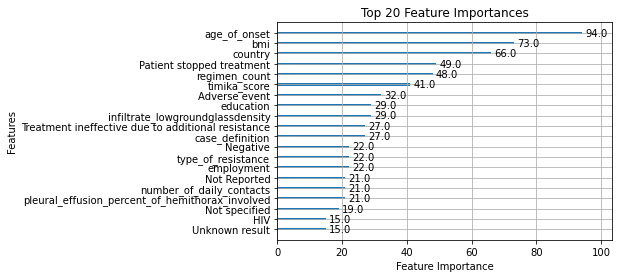

In [34]:
X_train_resampled_ = X_train_resampled.drop(columns=['Treatment ended', 'period_span'])
X_test_ =  X_test.drop(columns=['Treatment ended', 'period_span'])
# X_train_resampled_ = X_train_resampled[['Treatment ended']]
# X_test_ =  X_test[['Treatment ended']]
model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled_, X_test_, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)


## Correlation

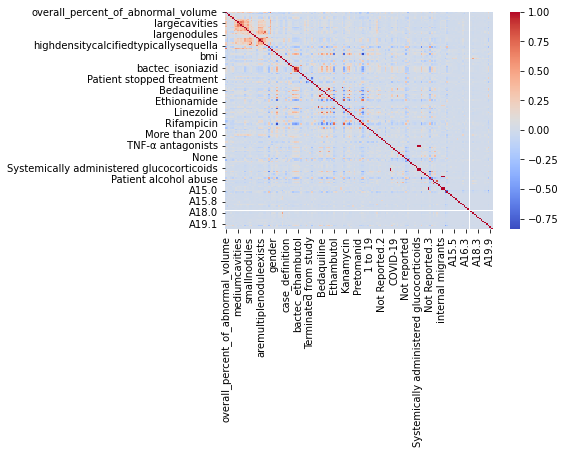

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = X_train_resampled.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Example: Simulating a DataFrame (replace this with your actual X_train_resampled DataFrame)
np.random.seed(42)
data = np.random.rand(100, 5)
X_train_resampled = pd.DataFrame(data, columns=["Feature_A", "Feature_B", "Feature_C", "Feature_D", "Feature_E"])

def get_highly_correlated_features(corr_matrix, threshold=0.8):
    """
    Identify feature pairs with correlations above a certain threshold.
    
    Args:
    - corr_matrix (pd.DataFrame): Correlation matrix.
    - threshold (float): Correlation value threshold.
    
    Returns:
    - List of tuples with feature pairs and their correlation value.
    """
    correlated_features = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_features.append(
                    (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                )
    return correlated_features


# Compute correlation matrix
corr_matrix = X_train_resampled.corr()

# Get feature pairs with correlations above a set threshold
threshold = 0.8  # Adjust threshold as needed
high_corr_features = get_highly_correlated_features(corr_matrix, threshold)

# Display highly correlated features
if high_corr_features:
    correlated_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])
    import ace_tools as tools; tools.display_dataframe_to_user(name="Highly Correlated Features", dataframe=correlated_df)
else:
    print("No features with correlation above the threshold.")


## permutation study

In [76]:
X_test.columns.shape

(156,)

In [77]:
X_train_resampled.columns.shape

(156,)

Testing Accuracy: 0.9110
Sensitivity (Recall): 0.9234
Specificity: 0.8618


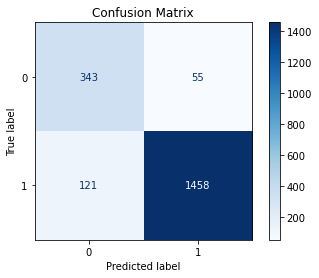

<Figure size 1080x1800 with 0 Axes>

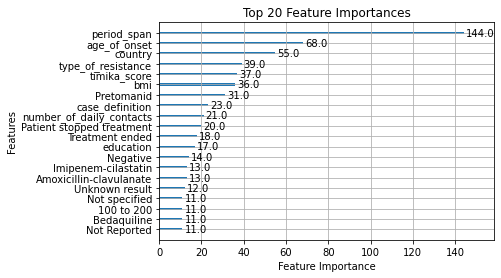

Feature Treatment ended: 0.0586
Feature type_of_resistance: 0.0260
Feature education: 0.0095
Feature overall_percent_of_abnormal_volume: 0.0093
Feature number_of_daily_contacts: 0.0081
Feature A15.0: 0.0055
Feature country: 0.0025
Feature aremultiplenoduleexists: 0.0009
Feature isanyclusterednoduleexists: 0.0006
Feature period_span: 0.0002
Feature highdensitycalcifiedtypicallysequella: 0.0002
Feature case_definition: 0.0000
Feature Amoxicillin-clavulanate: 0.0000
Feature Antiretroviral therapy: 0.0000
Feature Capreomycin: 0.0000
Feature Clarithromycin: 0.0000
Feature Aminoglycosides - injectible agents: 0.0000
Feature Amikacin: 0.0000
Feature Treatment ineffective due to additional resistance: 0.0000
Feature Clofazimine: 0.0000
Feature Terminated from study: 0.0000
Feature Bedaquiline: 0.0000
Feature Cotrimoxazol preventive: 0.0000
Feature Not Reported: 0.0000
Feature Kanamycin: 0.0000
Feature A19.9: 0.0000
Feature Ofloxacin: 0.0000
Feature Not Reported.1: 0.0000
Feature Mycobutin: 0.0

In [79]:
from sklearn.inspection import permutation_importance

imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

print('===Compute permutation importance===')
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Display importance
for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {X_test.columns[i]}: {result.importances_mean[i]:.4f}")


## RFE

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE


imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
# Example: Assuming X_train and y_train are already defined
# Define XGBoost model
model = XGBClassifier(reg_alpha=38, reg_lambda=69,  random_state=42)

# Perform RFE
rfe = RFE(estimator=model, n_features_to_select=1, step=1)  # Step=1 removes one feature at a time
rfe = rfe.fit(X_train_resampled, y_train_resampled)

# RFE rankings
feature_ranks = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe.ranking_,
    'Support': rfe.support_
}).sort_values(by='Rank')

# Display ranked features
print(feature_ranks)

# Train and evaluate the model with top N features
optimal_features = feature_ranks[feature_ranks['Support']]['Feature'].tolist()

# Select only optimal features
X_train_opt = X_train[optimal_features]
X_test_opt = X_test[optimal_features]

# Train model with optimal features
model.fit(X_train_opt, y_train)
y_pred_proba = model.predict_proba(X_test_opt)[:, 1]

# Evaluate performance
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC with optimal features: {auc:.4f}")


                Feature  Rank  Support
50      Treatment ended     1     True
37          period_span     2    False
30   type_of_resistance     3    False
57          Capreomycin     4    False
89             Negative     5    False
..                  ...   ...      ...
65     Fluoroquinolones   152    False
122  Patient drug abuse   153    False
124      TB care worker   154    False
154               A19.9   155    False
155      Not reported.1   156    False

[156 rows x 3 columns]
Model AUC with optimal features: 0.7296


In [13]:
print_full(feature_ranks)

                                                Feature  Rank  Support
50                                      Treatment ended     1     True
37                                          period_span     2    False
30                                   type_of_resistance     3    False
57                                          Capreomycin     4    False
89                                             Negative     5    False
47                                         Not Reported     6    False
35                                      case_definition     7    False
25                                              country     8    False
120                               Patient alcohol abuse     9    False
48                            Patient stopped treatment    10    False
64                                          Ethionamide    11    False
75                                       Not Reported.1    12    False
83                                p-aminosalicylic acid    13    False
105   